In [40]:
#import dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [41]:
#import directories
import pathlib
train_path = pathlib.Path("../Resources/Brain Tumor images/training")
test_path = pathlib.Path("../Resources/Brain Tumor images//testing")

In [42]:
#check directoy size
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2870


In [43]:
#set parameteres for datasets
batch_size = 32
img_height = 180
img_width = 180

In [44]:
#create datasets for training and testing
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [64]:
#store class names
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


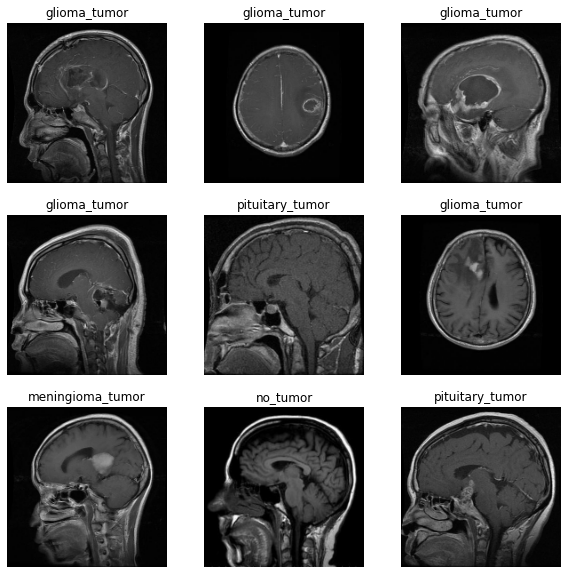

In [7]:
#plot images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
#check shape of batches in dataset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [9]:
#configure buffered prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
#layer to rescale RGB channel values from [0, 255] to [0, 1]
normalization_layer = layers.Rescaling(1./255)


In [11]:
#create the model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
#train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
90/90 [==============================] - 30s 319ms/step - loss: 0.8535 - accuracy: 0.6603 - val_loss: 1.9056 - val_accuracy: 0.4061
Epoch 2/10
90/90 [==============================] - 28s 307ms/step - loss: 0.4775 - accuracy: 0.8052 - val_loss: 1.5583 - val_accuracy: 0.5533
Epoch 3/10
90/90 [==============================] - 27s 302ms/step - loss: 0.2929 - accuracy: 0.8906 - val_loss: 2.5928 - val_accuracy: 0.6091
Epoch 4/10
90/90 [==============================] - 27s 299ms/step - loss: 0.1816 - accuracy: 0.9376 - val_loss: 2.3731 - val_accuracy: 0.6878
Epoch 5/10
90/90 [==============================] - 28s 312ms/step - loss: 0.1062 - accuracy: 0.9617 - val_loss: 3.1277 - val_accuracy: 0.7310
Epoch 6/10
90/90 [==============================] - 29s 326ms/step - loss: 0.0651 - accuracy: 0.9767 - val_loss: 3.7025 - val_accuracy: 0.7234
Epoch 7/10
90/90 [==============================] - 31s 346ms/step - loss: 0.0358 - accuracy: 0.9899 - val_loss: 4.1388 - val_accuracy: 0.7310

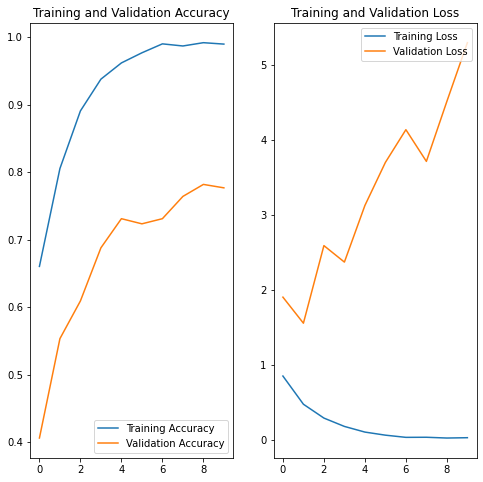

In [15]:
#plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [112]:
#testing
tumor_path = "C:/Users/matt_/Documents/Data_Bootcamp/Final Project/Brain Tumor images/Testing/glioma_tumor/image(60).jpg"
img = tf.keras.utils.load_img(
    tumor_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to glioma_tumor with a 99.99 percent confidence.


In [26]:
model.save("model_1.h5")

In [66]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

<tf.Tensor: shape=(394,), dtype=int32, numpy=
array([2, 1, 0, 0, 0, 2, 3, 1, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 2, 3, 1, 1, 0, 1, 3, 2, 2, 2, 3, 2, 1, 1, 3,
       1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 3, 2, 3, 2, 0, 1, 1, 1, 2, 2, 2, 3,
       3, 0, 3, 0, 1, 1, 3, 2, 1, 0, 3, 2, 1, 0, 3, 1, 2, 2, 3, 3, 1, 1,
       2, 2, 0, 1, 0, 3, 1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 0, 2, 0, 2,
       3, 3, 0, 2, 2, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 1, 0, 1, 1, 1, 1,
       2, 3, 3, 1, 1, 1, 2, 1, 1, 3, 1, 0, 1, 0, 0, 3, 2, 2, 1, 1, 0, 0,
       2, 3, 3, 0, 1, 3, 1, 0, 1, 2, 0, 3, 3, 2, 0, 2, 1, 2, 2, 3, 0, 1,
       0, 0, 3, 2, 0, 3, 0, 2, 0, 3, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 1, 3, 0, 0, 2, 1, 3, 0, 1,
       0, 2, 2, 2, 3, 0, 0, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 1, 3, 0,
       2, 1, 1, 0, 3, 2, 1, 2, 2, 1, 1, 1, 3, 2, 2, 2, 0, 2, 2, 0, 3, 0,
       3, 2, 0, 2, 3, 2, 0, 3, 1, 2, 3, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 3,
     

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(correct_labels, predicted_labels)

In [72]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33       100
           1       0.79      0.98      0.88       115
           2       0.66      1.00      0.80       105
           3       0.93      0.92      0.93        74

    accuracy                           0.78       394
   macro avg       0.85      0.78      0.73       394
weighted avg       0.84      0.78      0.73       394



<AxesSubplot:>

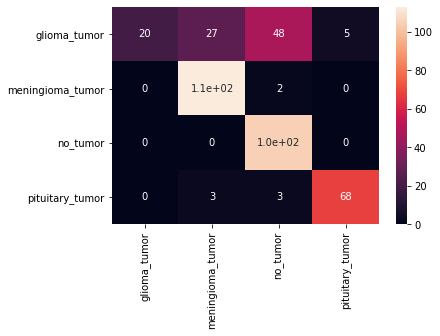

In [101]:
import seaborn as sns

sns.heatmap(matrix, annot=True,xticklabels=class_names,yticklabels=class_names)
